In [1]:
import numpy as np
import nltk
import matplotlib.pyplot as plt
import sklearn_crfsuite
from sklearn_crfsuite import metrics

In [4]:
nltk.download('brown')
nltk.download('universal_tagset')

from nltk.corpus import brown

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\VARTUL\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\VARTUL\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [5]:
#add start and end tags:
def add_start_end_tag(sentences_original):
    sentences=[""]*len(sentences_original)
    for i in range(len(sentences_original)):
        sentences[i]=[("<start>","<start>")]+sentences_original[i]+[("<end>","<end>")]
    return sentences

In [6]:
sentences_original = brown.tagged_sents(tagset='universal')

In [7]:
sentences = add_start_end_tag(sentences_original)

In [1]:
! pip install sklearn_crfsuite
import pickle
import nltk
import sklearn_crfsuite
import numpy as np
from nltk.corpus import brown
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

# Download the Brown corpus if you haven't already
nltk.download('brown')
nltk.download('universal_tagset')

# Load the Brown Corpus and use the universal tagset
brown_sents = brown.tagged_sents(tagset='universal')
master_confusion = []
tag_to_idx = {'<START>' : 0, 'DET': 1,'NOUN' : 2, 'ADJ' : 3, 'VERB' : 4, 'ADP' : 5, '.' : 6, '<END>' : 7, 'ADV' : 8, 'CONJ' : 9, 'PRT' : 10, 'PRON' : 11, 'NUM' : 12, 'X' : 13}
idx_to_tag = ["<START>","DET","NOUN","ADJ","VERB","ADP",".","<END>","ADV","CONJ","PRT","PRON","NUM","X"]
for j in range(len(idx_to_tag)):
    master_confusion.append([0]*len(idx_to_tag))
# Prepare the dataset in the required format
def prepare_brown_data():
    data = []
    for sent in brown_sents:
        tokens = [("<START>", "<START>")] + [(word, tag) for word, tag in sent] + [("<END>", "<END>")]
        data.append(tokens)
    return data

# Prepare the Brown dataset
brown_data = prepare_brown_data()

# Feature extraction functions
def sent2features(sent):
    features = []
    features.append(start_features())
    for i in range(1, len(sent) - 1):
        features.append(word2features(sent, i))
    features.append(end_features())
    return features

def start_features():
    return {'is_start': True}

def end_features():
    return {'is_end': True}

def word2features(sent, i):
    word = sent[i][0]
    features = {
        'bias': 1.0,
        'word': word,
        'is_first': i == 1,
        'is_last': i == len(sent) - 2,
        'is_capitalized': word[0].upper() == word[0],
        'is_all_caps': word.upper() == word,
        'is_all_lower': word.lower() == word,
        'prefix-1': word[0],
        'prefix-2': word[:2],
        'prefix-3': word[:3],
        'suffix-1': word[-1],
        'suffix-2': word[-2:],
        'suffix-3': word[-3:],
        'has_hyphen': '-' in word,
        'is_numeric': word.isdigit(),
        'capitals_inside': word[1:].lower() != word[1:]
    }
    return features

def sent2labels(sent):
    return [label for token, label in sent]

# Define the custom predict function
def custom_predict(test_sentence, crf):
    features = sent2features(test_sentence)
    transmission = get_transition_scores(crf)
    emission = get_state_scores(crf, features)

    l = {}
    l[0] = 1
    seq = [["<START>"]]
    labels = crf.classes_
    for k in range(1, len(features)):
        l_new = []
        l_dict = {}
        c = 0
        for i in l.keys():
            for j in range(len(labels)):
                prev = labels.index(seq[i][-1])
                prob = transmission[prev][j] + emission[k][j]
                l_new.append(seq[i] + [labels[j]])
                l_dict[c] = l[i] + prob
                c += 1
        l_dict = dict(sorted(l_dict.items(), key=lambda item: item[1], reverse=True)[:4])
        seq = []
        l = {}
        c = 0
        for b in l_dict.keys():
            seq.append(l_new[b])
            l[c] = l_dict[b]
            c += 1

    return seq[0]  # Remove <START> and <END>

# Helper functions to get transition and emission scores (same as before)
def get_transition_scores(crf_model):
    labels = crf_model.classes_
    transition_scores = np.zeros((len(labels), len(labels)))

    for (from_label, to_label), weight in crf_model.transition_features_.items():
        i = labels.index(from_label)
        j = labels.index(to_label)
        transition_scores[i, j] = weight

    return transition_scores

def get_state_scores(crf_model, feature_sequence):
    # Open the trained model

    # Get labels and pre-compute the label indices
    labels = crf_model.classes_
    label_indices = {label: idx for idx, label in enumerate(labels)}

    # Initialize state scores matrix
    state_scores = np.zeros((len(feature_sequence), len(labels)))

    # Extract all state features once
    state_features = crf_model.state_features_
        # 'bias': 1.0,
        # 'word': word,
        # 'is_first': i == 1,  # Adjusted because we have <START> tag
        # 'is_last': i == len(sent) - 2,  # Adjusted because of <END> tag
        # 'is_capitalized': word[0].upper() == word[0],
        # 'is_all_caps': word.upper() == word,
        # 'is_all_lower': word.lower() == word,
        # 'prefix-1': word[0],
        # 'prefix-2': word[:2],
        # 'prefix-3': word[:3],
        # 'suffix-1': word[-1],
        # 'suffix-2': word[-2:],
        # 'suffix-3': word[-3:],
        # 'has_hyphen': '-' in word,
        # 'is_numeric': word.isdigit(),
        # 'capitals_inside': word[1:].lower() != word[1:]

    boolean=['is_first','is_last','is_capitalized','is_all_caps','is_all_lower','has_hyphen','is_numeric','capitals_inside','is_start','is_end']

    # Iterate through each token's features in the sequence
    for t, features in enumerate(feature_sequence):
        # Create a counter for features
        for feat in features.keys():

            if feat in boolean:
                for label in labels :
                    if(features[feat]):
                      weight = state_features.get((feat, label), 0)
                      state_scores[t, label_indices[label]] += weight

            elif feat=="bias":
              for label in labels :

                    weight = state_features.get((feat, label), 0)
                    state_scores[t, label_indices[label]] += weight

            else:
              for label in labels :

                    weight = state_features.get((feat+":"+features[feat], label), 0)
                    state_scores[t, label_indices[label]] += weight

    return state_scores

# Cross-validation using KFold
def cross_validate_crf(brown_data, folds=5):
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)

    fold = 1
    for train_index, test_index in kf.split(brown_data):
        # Split the data
        train_sents = [brown_data[i] for i in train_index]
        test_sents = [brown_data[i] for i in test_index]

        # Extract features and labels for training and testing
        X_train = [sent2features(s) for s in train_sents]
        y_train = [sent2labels(s) for s in train_sents]
        X_test = [sent2features(s) for s in test_sents]
        y_test = [sent2labels(s) for s in test_sents]

        # Train the CRF model
        crf = sklearn_crfsuite.CRF(
            algorithm='lbfgs',
            c1=1.0,
            c2=1e-3,
            max_iterations=50,
            all_possible_transitions=True
        )
        crf.fit(X_train, y_train)

        with open('crf_model.pkl', 'wb') as f:
             pickle.dump(crf, f)

        # Predict using the custom predict function
        y_pred = []
        for sent in test_sents:
            y_pred.append(custom_predict(sent, crf))

        # Flatten the true and predicted labels for evaluation
        y_test_flat = [label for sent in y_test for label in sent]
        y_pred_flat = [label for sent in y_pred for label in sent]

        # Print the classification report for each fold
        print(f"Fold {fold} classification report:")
        report = classification_report(y_test_flat, y_pred_flat, zero_division=0)
        for num in range(0, len(y_test_flat)):

          test_sent = y_test_flat[num]
          pred_sent = y_pred_flat[num]
          master_confusion[tag_to_idx[test_sent]][tag_to_idx[pred_sent]] += 1
          # print(test_sent)
          # print(pred_sent)
        #   for t in range(0, len(test_sent)):
        #     master_confusion[tag_to_idx[test_sent[t]]][tag_to_idx[pred_sent[t]]] += 1
        print(report)
        fold += 1

# Run the 5-fold cross-validation
cross_validate_crf(brown_data, folds=5)
print(master_confusion)
with open('crf_confusion_matrix.pkl', 'wb') as file:
    # Dump the list of lists into the pickle file
    pickle.dump(master_confusion, file)

Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\VARTUL\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\VARTUL\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


Fold 1 classification report:
              precision    recall  f1-score   support

           .       1.00      1.00      1.00     29520
       <END>       1.00      1.00      1.00     11468
     <START>       1.00      1.00      1.00     11468
         ADJ       0.93      0.91      0.92     16772
         ADP       0.96      0.97      0.97     28768
         ADV       0.92      0.92      0.92     11271
        CONJ       0.99      1.00      0.99      7529
         DET       0.99      0.99      0.99     27474
        NOUN       0.96      0.97      0.97     54822
         NUM       0.97      0.99      0.98      2911
        PRON       0.98      0.98      0.98      9934
         PRT       0.92      0.91      0.91      5853
        VERB       0.97      0.96      0.97     36744
           X       0.82      0.25      0.39       329

    accuracy                           0.97    254863
   macro avg       0.96      0.92      0.93    254863
weighted avg       0.97      0.97      0.97    254

In [39]:
!pip install pickle
!pip install sklearn_crfsuite
import pickle


# Feature extraction functions
def sent2features(sent):
    features = []
    features.append(start_features())
    for i in range(1, len(sent) - 1):
        features.append(word2features(sent, i))
    features.append(end_features())
    return features

def start_features():
    return {'is_start': True}

def end_features():
    return {'is_end': True}

def word2features(sent, i):
    word = sent[i][0]
    features = {
        'bias': 1.0,
        'word': word,
        'is_first': i == 1,
        'is_last': i == len(sent) - 2,
        'is_capitalized': word[0].upper() == word[0],
        'is_all_caps': word.upper() == word,
        'is_all_lower': word.lower() == word,
        'prefix-1': word[0],
        'prefix-2': word[:2],
        'prefix-3': word[:3],
        'suffix-1': word[-1],
        'suffix-2': word[-2:],
        'suffix-3': word[-3:],
        'has_hyphen': '-' in word,
        'is_numeric': word.isdigit(),
        'capitals_inside': word[1:].lower() != word[1:]
    }
    return features

def sent2labels(sent):
    return [label for token, label in sent]

# Helper functions to get transition and emission scores (same as before)
def get_transition_scores(crf_model):
    labels = crf_model.classes_
    transition_scores = np.zeros((len(labels), len(labels)))

    for (from_label, to_label), weight in crf_model.transition_features_.items():
        i = labels.index(from_label)
        j = labels.index(to_label)
        transition_scores[i, j] = weight

    return transition_scores

def get_state_scores(crf_model, feature_sequence):
    # Open the trained model

    # Get labels and pre-compute the label indices
    labels = crf_model.classes_
    label_indices = {label: idx for idx, label in enumerate(labels)}

    # Initialize state scores matrix
    state_scores = np.zeros((len(feature_sequence), len(labels)))

    # Extract all state features once
    state_features = crf_model.state_features_
        # 'bias': 1.0,
        # 'word': word,
        # 'is_first': i == 1,  # Adjusted because we have <START> tag
        # 'is_last': i == len(sent) - 2,  # Adjusted because of <END> tag
        # 'is_capitalized': word[0].upper() == word[0],
        # 'is_all_caps': word.upper() == word,
        # 'is_all_lower': word.lower() == word,
        # 'prefix-1': word[0],
        # 'prefix-2': word[:2],
        # 'prefix-3': word[:3],
        # 'suffix-1': word[-1],
        # 'suffix-2': word[-2:],
        # 'suffix-3': word[-3:],
        # 'has_hyphen': '-' in word,
        # 'is_numeric': word.isdigit(),
        # 'capitals_inside': word[1:].lower() != word[1:]

    boolean=['is_first','is_last','is_capitalized','is_all_caps','is_all_lower','has_hyphen','is_numeric','capitals_inside','is_start','is_end']

    # Iterate through each token's features in the sequence
    for t, features in enumerate(feature_sequence):
        # Create a counter for features
        for feat in features.keys():

            if feat in boolean:
                for label in labels :
                    if(features[feat]):
                      weight = state_features.get((feat, label), 0)
                      state_scores[t, label_indices[label]] += weight

            elif feat=="bias":
              for label in labels :

                    weight = state_features.get((feat, label), 0)
                    state_scores[t, label_indices[label]] += weight

            else:
              for label in labels :

                    weight = state_features.get((feat+":"+features[feat], label), 0)
                    state_scores[t, label_indices[label]] += weight

    return state_scores

def custom_predict(test_sentence, crf):
    features = sent2features(test_sentence)
    transmission = get_transition_scores(crf)
    emission = get_state_scores(crf, features)

    l = {}
    l[0] = 1
    seq = [["<START>"]]
    labels = crf.classes_
    for k in range(1, len(features)):
        l_new = []
        l_dict = {}
        c = 0
        for i in l.keys():
            for j in range(len(labels)):
                prev = labels.index(seq[i][-1])
                prob = transmission[prev][j] + emission[k][j]
                l_new.append(seq[i] + [labels[j]])
                l_dict[c] = l[i] + prob
                c += 1
        l_dict = dict(sorted(l_dict.items(), key=lambda item: item[1], reverse=True)[:4])
        seq = []
        l = {}
        c = 0
        for b in l_dict.keys():
            seq.append(l_new[b])
            l[c] = l_dict[b]
            c += 1
    # print(seq[0],test_sentence)
    return seq[0]
def predict_sentence(crf, sentence):
    # Prepare the sentence in the required format
    formatted_sentence = sentence#[(word, "") for word in sentence.split()]

    # Predict tags using the custom Viterbi-like 
    # print(formatted_sentence)
    predicted_tags = custom_predict(formatted_sentence, crf)

    # Return a list of (word, tag) tuples
    return predicted_tags#list(zip(sentence.split(" "), predicted_tags))

with open('crf_model.pkl', 'rb') as f:
    crf = pickle.load(f)

# sentence = "<START> The old man the boats . <END>"
# prediction = predict_sentence(crf, sentence)
# print("Predicted Tags:", prediction)

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


Defaulting to user installation because normal site-packages is not writeable


In [25]:
def replace_tags(sentence):
    new_sentence=[]
    for i in sentence:
        j = (i[0], "")
        new_sentence.append(j)
    return new_sentence

In [31]:
sentence = "<START> The old man the boats . <END>"
prediction = predict_sentence(crf, replace_tags(sentences_original[0]))
print("Predicted Tags:", prediction)

[('<start>', ''), ('The', ''), ('Fulton', ''), ('County', ''), ('Grand', ''), ('Jury', ''), ('said', ''), ('Friday', ''), ('an', ''), ('investigation', ''), ('of', ''), ("Atlanta's", ''), ('recent', ''), ('primary', ''), ('election', ''), ('produced', ''), ('``', ''), ('no', ''), ('evidence', ''), ("''", ''), ('that', ''), ('any', ''), ('irregularities', ''), ('took', ''), ('place', ''), ('.', ''), ('<end>', '')]
Predicted Tags: ['<START>', 'DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'ADJ', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.', '<END>']


In [3]:
with open('crf_confusion_matrix.pkl', 'rb') as file:
    crf_confusion_matrix = pickle.load(file)

print(crf_confusion_matrix)


[[57340, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 135854, 36, 4, 1, 515, 0, 0, 89, 55, 0, 460, 3, 2], [0, 35, 267658, 3158, 3724, 61, 4, 0, 324, 2, 83, 21, 417, 71], [0, 2, 3711, 76650, 974, 85, 0, 0, 2215, 1, 59, 2, 18, 4], [0, 3, 5253, 712, 176373, 213, 0, 0, 166, 0, 18, 0, 8, 4], [0, 871, 69, 50, 104, 140426, 20, 0, 1115, 148, 1773, 186, 1, 3], [0, 0, 4, 0, 0, 0, 147559, 0, 0, 0, 0, 0, 0, 2], [0, 0, 0, 0, 0, 0, 0, 57340, 0, 0, 0, 0, 0, 0], [0, 218, 350, 1761, 72, 1911, 0, 0, 51343, 102, 465, 15, 0, 2], [0, 48, 4, 0, 2, 5, 0, 0, 55, 38036, 0, 0, 0, 1], [0, 2, 273, 80, 43, 2364, 0, 0, 183, 0, 26879, 3, 0, 2], [0, 248, 36, 1, 3, 648, 0, 0, 5, 0, 9, 48383, 0, 1], [0, 0, 135, 38, 3, 0, 6, 0, 0, 0, 0, 0, 14690, 2], [0, 21, 766, 60, 50, 29, 24, 0, 11, 4, 2, 6, 8, 405]]


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def heatmap(confusion_matrix, x_labels, y_labels, x_description, y_description):
    # Normalize the data
    data = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, np.newaxis]

    # Create the heatmap

    plt.figure(figsize=(13, 13))
    plt.imshow(data, cmap='Spectral', interpolation='none')



    # Add a colorbar
    plt.colorbar()

    # Add text annotations
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            plt.text(j, i, f'{data[i, j]:.2f}', ha='center', va='center', color='black')

    # Add labels
    plt.title('Heatmap Example')
    plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels, rotation=45)  # Rotation for better readability
    plt.yticks(ticks=np.arange(len(y_labels)), labels=y_labels)

    plt.xlabel(x_description)
    plt.ylabel(y_description)

    # Display the plot
    plt.show()


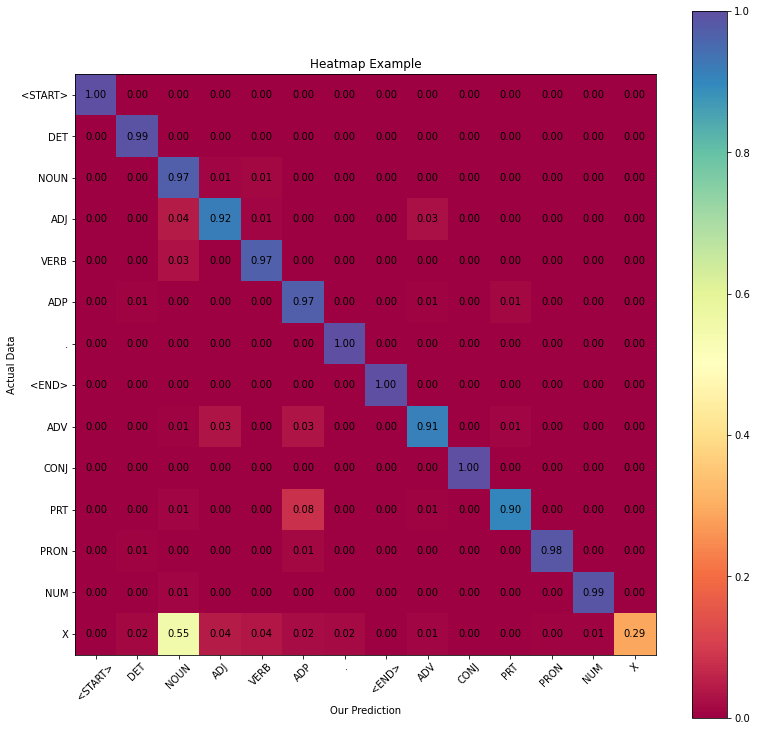

In [6]:
idx_to_tag = ["<START>","DET","NOUN","ADJ","VERB","ADP",".","<END>","ADV","CONJ","PRT","PRON","NUM","X"]
heatmap(master_confusion, idx_to_tag, idx_to_tag, "Our Prediction", "Actual Data")

In [3]:
import numpy as np
#splits data in k sets:
def k_splits (k, data):
    splits = {}
    n = len(data)//k
    for i in range(0, k):
        i = int(i)
        if(i+1 == k):
            splits[i]= data[n*i : ]
        else:
            splits[i]=data[n*i : n*(i+1)]
    return splits
def add_start_end_tag(sentences_original):
    sentences=[""]*len(sentences_original)
    for i in range(len(sentences_original)):
        sentences[i]=[("<start>","<start>")]+sentences_original[i]+[("<end>","<end>")]
    return sentences
def remove_tags(sentence):
    new_sentence=[]
    for i in sentence:
        new_sentence.append(i[0])

    # print(new_sentence)

    return new_sentence
class HMM_model:
    def __init__(self):
        self.confusion_matrix=None
        self.transition_matrix=None
        self.emission_matrix=None
        self.tags_to_idx=None
        self.count_of_each_tag=None
        self.idx_to_tag=None
        self.word_to_idx=None
        self.idx_to_word=None
    
    def creat_tags_meta(self,sentences):
        
        #tag_to_idx: given a tag, what is its index : tags dict {"tag" : "tag_index"}
        #idx_to_tag: given an index what is the tag : tags_reverse list of string
        #count_of_each_tag: count of each tag
        self.tag_to_idx={}
        self.idx_to_tag=[]
        cnt = 0
        self.count_of_each_tag=[]
        for i in range(len(sentences)):
            for j in sentences[i]:
                if j[1] not in self.tag_to_idx:
                    self.tag_to_idx[j[1]] = cnt
                    self.idx_to_tag.append(j[1])
                    self.count_of_each_tag.append(0)
                    cnt += 1
                self.count_of_each_tag[self.tag_to_idx[j[1]]]+=1


    def create_word_idx_translation(self,sentences):
        #word to index number
        #word_to_idx is word to index number
        #idx_to_word
        
        idx = 0
        self.word_to_idx={}
        self.idx_to_word = []
        # word_to_idx["<start>"]=idx
        for sentence in sentences:
            for tup in sentence:
                if tup[0] not in self.word_to_idx:
                    
                    self.word_to_idx[tup[0]]=idx
                    idx += 1
                    self.idx_to_word.append(tup[0])
        self.word_to_idx["<unknown>"]=idx
        self.idx_to_word.append("<unknown>")

        # print('idx--------------------------------', idx)
        # print('worddict--------------------------------', len(word_to_idx))


    def create_transition_matrix(self,sentences):
        #creating transition matrix
        #bigram_matrix : count of every bigram tags
        #transmission_matrix : probability of every bigram tags 
        self.bigram_matrix = []
        self.transition_matrix = []
        total_tags = len(self.count_of_each_tag)
        for i in range(total_tags): 
            self.bigram_matrix.append([0]*total_tags)
            self.transition_matrix.append([0]*total_tags)

        #creating a bigram matrix
        for sentence in sentences:
            for j in range(len(sentence)-1):
                self.bigram_matrix[self.tag_to_idx[sentence[j][1]]][self.tag_to_idx[sentence[j+1][1]]]+=1
        # print(bigram_matrix)
        
        #create transition matrix A
        for i in range(total_tags):
            for j in range(total_tags):
                self.transition_matrix[i][j]=(self.bigram_matrix[i][j]+1)/(self.count_of_each_tag[i] + len(self.count_of_each_tag))  #adding 1 to numerator and total unique tags in denominator for smoothing(Laplace)
        # print(transition_matrix)


    def create_emission_matrix(self,sentences):
        #emission_matrix : given a word, what is the probability of tag
        #emission_count_matrix : given a word, what is the count of each tag that it can have
        # words = list(brown.words())
        words_cnt = len(self.word_to_idx)
        total_tags = len(self.tag_to_idx)
        self.emission_matrix = []
        
        for i in range(words_cnt):
            self.emission_matrix.append([0]*total_tags)
        # print("--------------------------------------",len(word_to_idx))
        # print("------------------------", len(emission_matrix))
        # print("------------------------", word_to_idx['<unknown>'])
        
        for sentence in sentences:
            for j in sentence:
                self.emission_matrix[self.word_to_idx[j[0]]][self.tag_to_idx[j[1]]]+=1

        emission_count_matrix = self.emission_matrix

        for i in range(words_cnt):
            for j in range(total_tags):
                self.emission_matrix[i][j] = (self.emission_matrix[i][j]+1)/(self.count_of_each_tag[j] + words_cnt)
        # print("------------------------", emission_matrix[word_to_idx['unknown'])

        # handling missing case
        aux=[0]*len(self.tag_to_idx.keys())
        # print(tag_to_idx)
        aux[self.tag_to_idx['NOUN']]=self.count_of_each_tag[self.tag_to_idx['NOUN']]/total_tags
        aux[self.tag_to_idx['VERB']]=self.count_of_each_tag[self.tag_to_idx['VERB']]/total_tags
        aux[self.tag_to_idx['ADV']]=self.count_of_each_tag[self.tag_to_idx['ADV']]/total_tags
        aux[self.tag_to_idx['ADJ']]=self.count_of_each_tag[self.tag_to_idx['ADJ']]/total_tags
        # print(aux)
        self.emission_matrix[self.word_to_idx['<unknown>']]=aux


    def build_confusion_matrix(self,actual,predicted):
        #cm: confusion matrix
        for i in range(len(actual)):
            self.confusion_matrix[self.tag_to_idx[actual[i][1]]][self.tag_to_idx[predicted[i][1]]]+=1

    def HMM_logic(self,input_sentence):
        # print(tags_dict)
        tags_output=["<start>"]
        last_prob = 1
        viterbi=[]
        for i in range(len(self.tag_to_idx)):
            viterbi.append(([0])*len(input_sentence))
        
        viterbi[self.tag_to_idx["<start>"]][0]=1
        
        for i in range(1, len(input_sentence)):
            word_prob=0
            tags=""
            curr_ob = input_sentence[i]
            if curr_ob not in self.word_to_idx:
                curr_ob="<unknown>"
            for curr_tag in self.tag_to_idx:
                max_prob=0
                for prev_tag in self.tag_to_idx:
                    temp = self.transition_matrix[self.tag_to_idx[prev_tag]][self.tag_to_idx[curr_tag]]*self.emission_matrix[self.word_to_idx[curr_ob]][self.tag_to_idx[curr_tag]]*viterbi[self.tag_to_idx[prev_tag]][i-1]
                    if temp>max_prob:
                        max_prob=temp
                viterbi[self.tag_to_idx[curr_tag]][i]=max_prob
                if max_prob>word_prob:
                    word_prob=max_prob
                    tags=curr_tag
            if tags=='':
                tags='X'
            tags_output.append(tags)

        return [(input_sentence[i],tags_output[i]) for i in range(len(input_sentence))] 
    



    def train_model(self,sentences_original, k):

        model=HMM_model()

        sentences = add_start_end_tag(sentences_original)
        
        #spliting data into k splits
        cross_validation_set=k_splits(k,sentences)
        keys=list(cross_validation_set.keys())

        #creating master meta data i.e. over whole corpus
        self.creat_tags_meta(sentences)
        self.create_word_idx_translation(sentences)
        #instializing master transition, emission and confusion matrices
        master_transition_matrix = []
        master_emission_matrix = []
        master_confusion_matrix = []

        for i in range(len(self.count_of_each_tag)):
            master_transition_matrix.append([0]*len(self.count_of_each_tag))
            master_confusion_matrix.append([0]*len(self.count_of_each_tag))

        for i in range(len(self.word_to_idx)):
            master_emission_matrix.append([0]*len(self.count_of_each_tag))



        #model building and traing on k sets
        for i in keys:

            #**********************------------------create test and train------------------************************************
            train_data=[]
            for j in cross_validation_set.keys():
                if j!=i:
                    train_data+=cross_validation_set[j]

            test_data=cross_validation_set[i]
            #**********************---------------------------------------************************************
            

            #**********************---------------create tags and words meta data------------------------************************************
            model.creat_tags_meta(train_data)
            model.create_word_idx_translation(train_data)
            #**********************---------------------------------------************************************


            #**********************---------------build transition and emission matrix------------------------************************************
            
            #bigram_matrix : count of every bigram tags
            #transmission_matrix : probability of every bigram tags
            #emission_count_matrix : given a word, what is the count of each tag that it can have
            #emission_matrix : given a word, what is the probability of tag
            model.create_transition_matrix(train_data)
            model.create_emission_matrix(train_data)

            #**********************---------------------------------------************************************
            
            #**********************---------------initialize confustion matrix------------------------************************************
            #confusion_matrix : A matrix with rows having actual tag and columns showing predicted tag
            model.confusion_matrix=[]
            for j in range(len(model.count_of_each_tag)):
                model.confusion_matrix.append([0]*len(model.count_of_each_tag))
            #**********************---------------------------------------************************************


            #**********************---------------bulding confustion matrix------------------------************************************
            coun=0
            for sen in test_data:
                coun+=1
                tags_output = model.HMM_logic(remove_tags(sen))
                model.build_confusion_matrix(sen,tags_output)
            #**********************---------------------------------------************************************

            
            


            #**********************---------------build masters------------------------************************************
            for i in range(len(model.count_of_each_tag)):
                row = model.idx_to_tag[i]
                for j in range(len(self.count_of_each_tag)):
                    col = model.idx_to_tag[j]
                    master_transition_matrix[self.tag_to_idx[row]][self.tag_to_idx[col]] += model.transition_matrix[i][j]
                    master_confusion_matrix[self.tag_to_idx[row]][self.tag_to_idx[col]] += model.confusion_matrix[i][j]
            
            for i in range(len(model.word_to_idx)):
                row = model.idx_to_word[i]
                for j in range(len(self.count_of_each_tag)):
                    col = model.idx_to_tag[j]
                    master_emission_matrix[self.word_to_idx[row]][self.tag_to_idx[col]] += model.emission_matrix[i][j]
            
            #**********************---------------------------------------*******************************************
                

        self.confusion_matrix = np.array(master_confusion_matrix)/k
        self.transition_matrix=np.array(master_transition_matrix)/k
        self.emission_matrix=np.array(master_emission_matrix)/k


    
            



In [4]:
import numpy as np
import nltk
import matplotlib.pyplot as plt

In [5]:
nltk.download('brown')
nltk.download('universal_tagset')

from nltk.corpus import brown

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\VARTUL\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\VARTUL\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [6]:
#taking data from corpus
sentences_original = brown.tagged_sents(tagset='universal')
sentences_original = add_start_end_tag(sentences_original)

In [7]:
model = HMM_model()
model.train_model(sentences_original, 5)

In [21]:
HMM_predicted_data = []

# HMM_sentences_original[0]
# sentence = remove_tags(sentences_original[0])
sentence = ['<start>','I', 'am', 'attending', 'lecture', '<end>']

HMM_predicted_data.append(model.HMM_logic(sentence))

# for i in range(0, len(HMM_sentences_original)):
#     HMM_predicted_data.append(predict(HMM_sentences_original[i]))
HMM_predicted_data   

[[('<start>', '<start>'),
  ('I', 'PRON'),
  ('am', 'VERB'),
  ('attending', 'VERB'),
  ('lecture', 'NOUN'),
  ('<end>', '<end>')]]

In [22]:
# model.confusion_matrix
with open('hmm_confusion_matrix.pkl', 'wb') as file:
    # Dump the list of lists into the pickle file
    pickle.dump(model.confusion_matrix, file)

In [24]:
with open('hmm_confusion_matrix.pkl', 'rb') as file:
    hmm_confusion_matrix = pickle.load(file)

# print(hmm_confusion_matrix)

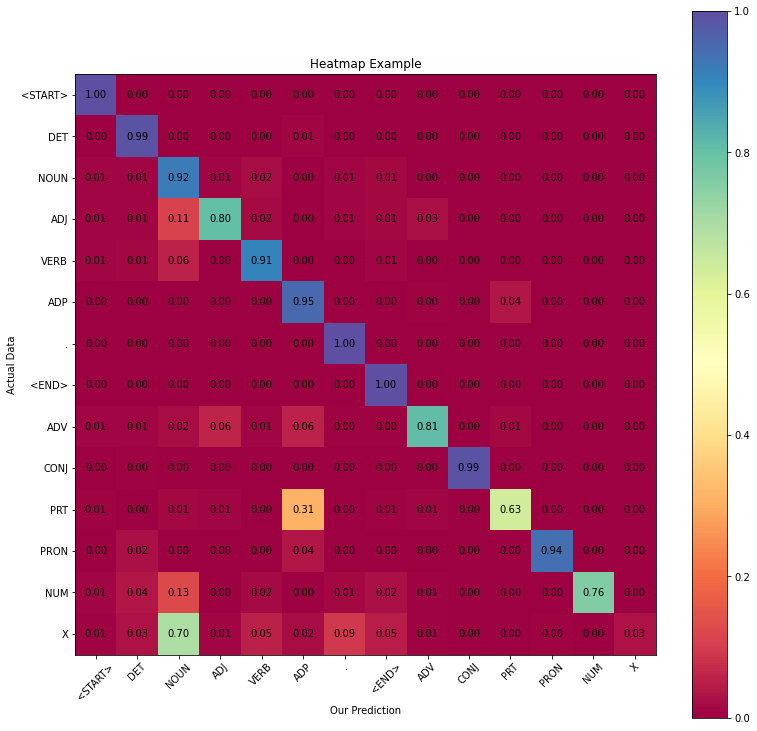

In [25]:
idx_to_tag = ["<START>","DET","NOUN","ADJ","VERB","ADP",".","<END>","ADV","CONJ","PRT","PRON","NUM","X"]
heatmap(hmm_confusion_matrix, idx_to_tag, idx_to_tag, "Our Prediction", "Actual Data")

In [ ]:
import pickle
with open('comparision.pkl', 'rb') as f:
    HMM_predicted_data, CRF_predicted_data= pickle.load(f)
temp = 0
for i in range(0, len(HMM_predicted_data)):
    if(HMM_predicted_data[i][len(HMM_predicted_data[i])-1] == "."):
        HMM_predicted_data[i][len(HMM_predicted_data[i])-1] = "<end>"
        temp +=1
print(temp)

# Verify the contents
# for i in range(0, len(HMM))
check = 0
hmm_list = []
crf_list = []
for i in range(0, len(HMM_predicted_data)):
    if(len(HMM_predicted_data[i]) == len(CRF_predicted_data[i])):
        hmm_list.append(HMM_predicted_data[i])
        crf_list.append(CRF_predicted_data[i])
print(check)
print(HMM_predicted_data[0:5])
print(CRF_predicted_data[0:5])

In [34]:
def only_tags(sentence):
    new_sentence=[]
    for i in sentence:
        new_sentence.append(i[1])

    # print(new_sentence)

    return new_sentence

In [32]:
sentence = "<START> The old man the boats . <END>"
prediction = predict_sentence(crf, replace_tags(sentences_original[0]))
print("Predicted Tags:", prediction)

[('<start>', ''), ('The', ''), ('Fulton', ''), ('County', ''), ('Grand', ''), ('Jury', ''), ('said', ''), ('Friday', ''), ('an', ''), ('investigation', ''), ('of', ''), ("Atlanta's", ''), ('recent', ''), ('primary', ''), ('election', ''), ('produced', ''), ('``', ''), ('no', ''), ('evidence', ''), ("''", ''), ('that', ''), ('any', ''), ('irregularities', ''), ('took', ''), ('place', ''), ('.', ''), ('<end>', '')]
Predicted Tags: ['<START>', 'DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'ADJ', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.', '<END>']


In [36]:
print(only_tags(model.HMM_logic(remove_tags(sentences_original[0]))))

['<start>', 'DET', 'NOUN', 'NOUN', '.', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.', '<end>']


In [58]:
#for CRF prediction ==> 
#I/P ==> [('<start>', ''), ('The', ''), ('Fulton', ''), ('County', ''), ('Grand', ''), ('Jury', ''), ('said', ''), ('Friday', ''), ('an', ''), ('investigation', ''), ('of', ''), ("Atlanta's", ''), ('recent', ''), ('primary', ''), ('election', ''), ('produced', ''), ('``', ''), ('no', ''), ('evidence', ''), ("''", ''), ('that', ''), ('any', ''), ('irregularities', ''), ('took', ''), ('place', ''), ('.', ''), ('<end>', '')]
#O/P ==> ['<START>', 'DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'ADJ', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.', '<END>']
#for HMM prediction ==> 
#I/P ==> [('<start>'), ('The'), ('Fulton'), ('County'), ('<end>')]
#O/P ==> list of tuple of word tag pair
CRF_predicted_data = []
HMM_predicted_data = []

for i in range(0, len(sentences_original)):
    hmm_sent = remove_tags(sentences_original[i])
    crf_sent = sentences_original[i]
    # if(len(hmm_sent) == len(crf_sent)):
    HMM_predicted_data.append(only_tags(model.HMM_logic(hmm_sent)))
    CRF_predicted_data.append(predict_sentence(crf, replace_tags(crf_sent)))
# print(HMM_predicted_data[0:10])

# with open('HMM_prediction.pkl', 'wb') as f:
    # pickle.dump((HMM_predicted_data, CRF_predicted_data), f)

In [46]:
CRF_predicted_data = [[word.replace("<START>", "<start>").replace("<END>", "<end>") for word in sublist] for sublist in CRF_predicted_data]

In [47]:
cnt = 0
for i in range(0, len(HMM_predicted_data)):
    if(len(HMM_predicted_data[i]) != len(CRF_predicted_data[i])):
        cnt+=1
        # hmm_list.append(HMM_predicted_data[i])
        # crf_list.append(CRF_predicted_data[i])
cnt

0

In [55]:
with open('Comparision.pkl', 'wb') as f:
    pickle.dump((HMM_predicted_data, CRF_predicted_data), f)

In [48]:
def build_confusion_matrix(actual,predicted):
    idx_to_tag = ["<start>","DET","NOUN","ADJ","VERB","ADP",".","<end>","ADV","CONJ","PRT","PRON","NUM","X"]
    tag_to_idx = {'<start>' : 0, 'DET': 1,'NOUN' : 2, 'ADJ' : 3, 'VERB' : 4, 'ADP' : 5, '.' : 6, '<end>' : 7, 'ADV' : 8, 'CONJ' : 9, 'PRT' : 10, 'PRON' : 11, 'NUM' : 12, 'X' : 13}
    
    # idx = 0
    # for tag in idx_to_tag:
    #     tag_to_index[tag] = idx
    #     idx += 1

    confusion_matrix=[]
    for i in range(len(idx_to_tag)):
        confusion_matrix.append([0]*len(idx_to_tag))
    for i in range(len(actual)):
        # print(i)
        for j in range(len(actual[i])):
            confusion_matrix[tag_to_idx[actual[i][j]]][tag_to_idx[predicted[i][j]]]+=1
    return confusion_matrix

In [49]:
cm = build_confusion_matrix(CRF_predicted_data, HMM_predicted_data)


In [51]:
def heatmap(confusion_matrix, x_labels, y_labels, x_description, y_description):

    # Example data
    # data = confusion_matrix/np.sum(confusion_matrix,axis=1)
    data = np.array(confusion_matrix)
    plt.figure(figsize=(20,20))
    # Create the heatmap
    plt.imshow(data,  cmap='Spectral', interpolation='none')

    # Add a colorbar
    plt.colorbar()

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            plt.text(j, i, f'{data[i, j]}', ha='center', va='center', color='black')

    # Add labels (optional)
    
    plt.title('Heatmap Example')
    plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels, rotation=45)  # Rotation for better readability
    plt.yticks(ticks=np.arange(len(y_labels)), labels=y_labels)

    plt.xlabel(x_description)
    plt.ylabel(y_description)
    # Display the plot
    return plt.show()


In [53]:
def heatmap_percent(confusion_matrix, x_labels, y_labels, x_description, y_description):
    temp = [row[:] for row in confusion_matrix]
    data = []
    for i in range(len(temp)):
        sum = 0
        for j in range(len(temp[i])):
            sum += temp[i][j]
        data.append(sum)
    data = np.sum(temp,axis=1)
    
    # print(data)
    # Example data
    for i in range(len(temp)):
        for j in range(len(temp[i])):
            temp[i][j]/=data[i]
    temp = np.array(temp)
    
    
    plt.figure(figsize=(13,13))
    # Create the heatmap
    plt.imshow(temp,  cmap='Spectral', interpolation='none')

    # Add a colorbar
    plt.colorbar()

    for i in range(temp.shape[0]):
        for j in range(temp.shape[1]):
            plt.text(j, i, f'{temp[i, j]:.2f}', ha='center', va='center', color='black')

    # Add labels (optional)
    
    plt.title('Heatmap Example')
    plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels, rotation=45)  # Rotation for better readability
    plt.yticks(ticks=np.arange(len(y_labels)), labels=y_labels)

    plt.xlabel(x_description)
    plt.ylabel(y_description)
    # Display the plot
    return plt.show()


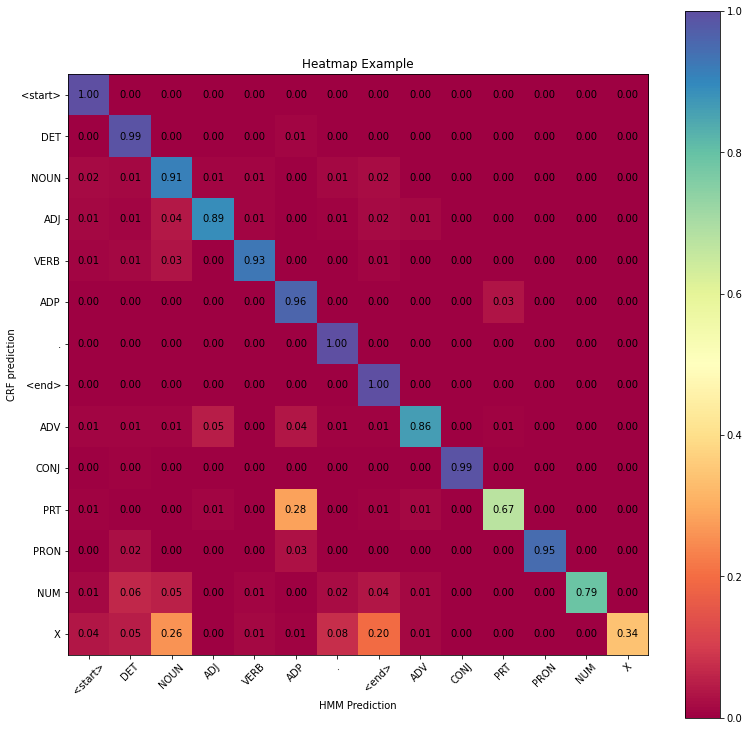

In [54]:
idx_to_tag = ["<start>","DET","NOUN","ADJ","VERB","ADP",".","<end>","ADV","CONJ","PRT","PRON","NUM","X"]
heatmap_percent(cm, idx_to_tag, idx_to_tag, "HMM Prediction", "CRF prediction")

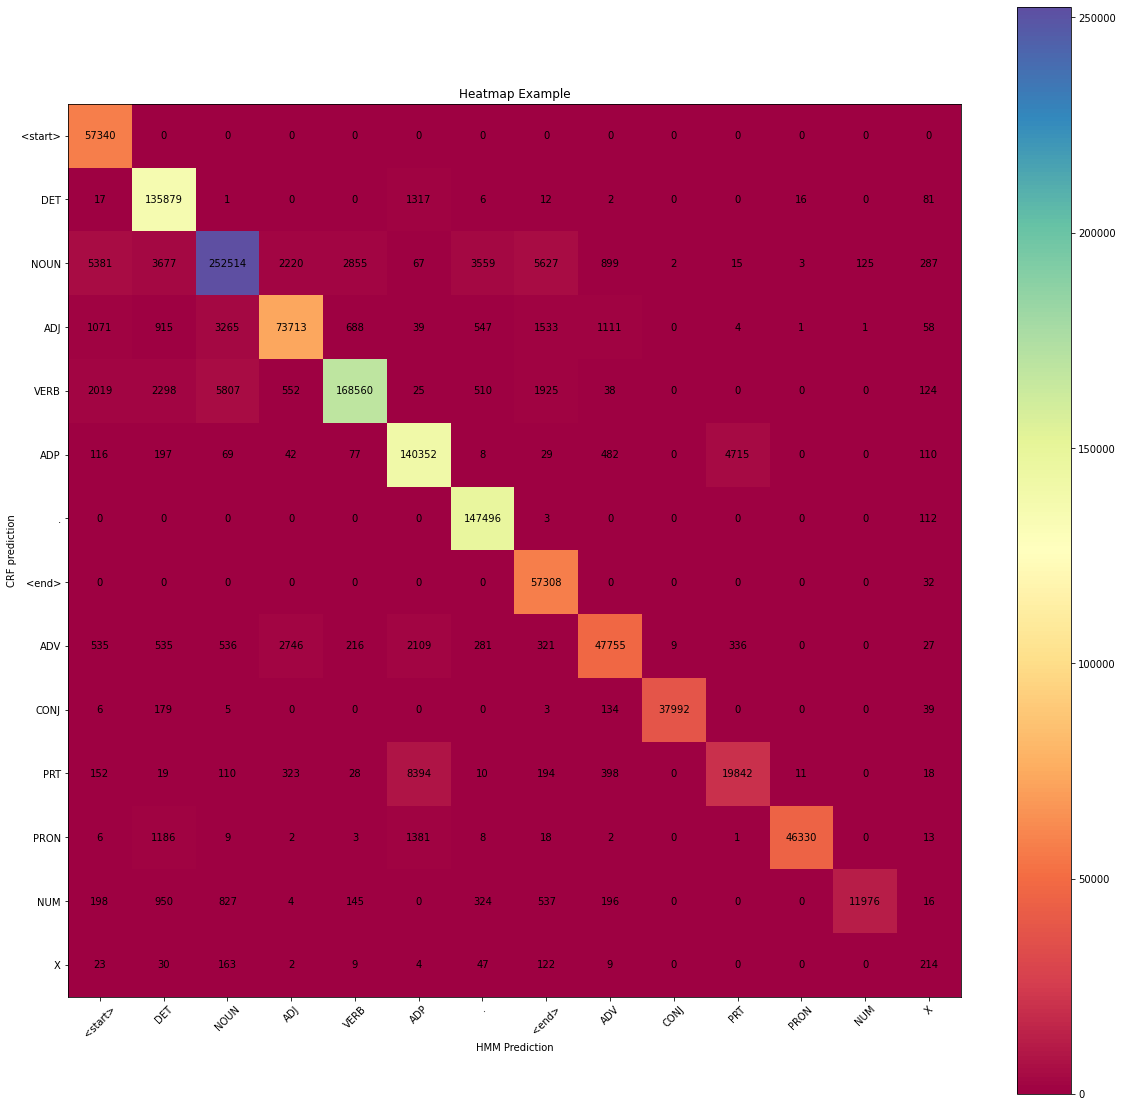

In [56]:
idx_to_tag = ["<start>","DET","NOUN","ADJ","VERB","ADP",".","<end>","ADV","CONJ","PRT","PRON","NUM","X"]
heatmap(cm, idx_to_tag, idx_to_tag, "HMM Prediction", "CRF prediction")